# Introduction

The Stanford Dogs dataset is a benchmark dataset for fine-grained image classification. It contains 20,580 color images of dogs belonging to 120 different breeds from around the world. The images and annotations are derived from ImageNet and were originally collected for the task of distinguishing between visually similar dog breeds, which is much harder than generic “dog vs. cat” style classification. 

Link for the project https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/data

Standford Dog Dataset http://vision.stanford.edu/aditya86/ImageNetDogs/


Each class corresponds to a specific dog breed (e.g., Chihuahua, Pug, German Shepherd), and the dataset includes train/test splits commonly used in the literature: 12,000 images for training and 8,580 images for testing. 

 The images are “in the wild”: dogs appear in varied poses, lighting conditions, backgrounds, and occlusions, which leads to high intra-class variation (same breed looks very different from image to image) and low inter-class variation (some breeds look extremely similar to each other).

**Import libraries**

In [3]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

from collections import Counter
import random

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix


# EDA

Load breeds & count images

In [5]:
breed_list = os.listdir("../input/stanford-dogs-dataset/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("../input/stanford-dogs-dataset/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


Map labels to numbers

In [6]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

Display some cute dog pictures

In [7]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "../input/stanford-dogs-dataset/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02091635-otterhound


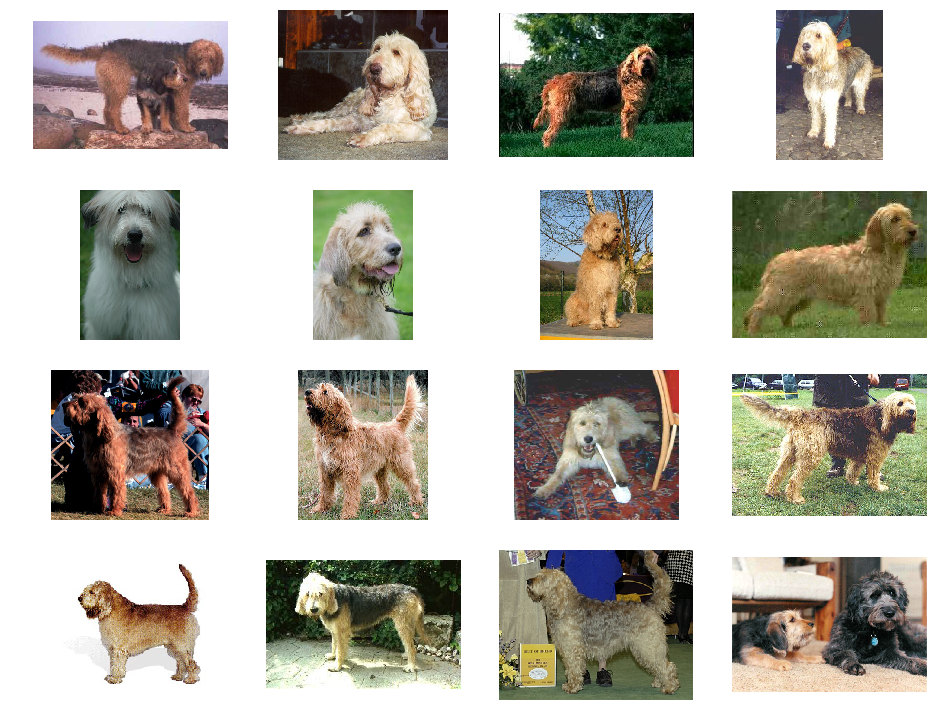

In [8]:
print(breed_list[0])
show_dir_images(breed_list[0], 16)

Visualize class distribution

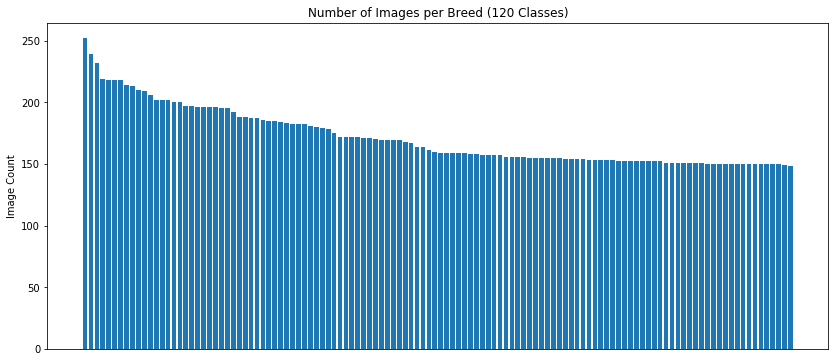

In [9]:
base_dir = "../input/stanford-dogs-dataset/images/Images/"

breed_counts = {}
for breed in breed_list:
    img_dir = os.path.join(base_dir, breed)
    breed_counts[breed] = len(os.listdir(img_dir))

df_counts = pd.DataFrame({"breed": list(breed_counts.keys()),
                          "count": list(breed_counts.values())})

df_counts = df_counts.sort_values("count", ascending=False)

plt.figure(figsize=(14,6))
plt.bar(df_counts["breed"], df_counts["count"])
plt.xticks([], [])     # too many labels, hide them
plt.ylabel("Image Count")
plt.title("Number of Images per Breed (120 Classes)")
plt.show()

Clean up /kaggle/working/ folder

In [11]:
import shutil

folder = "/kaggle/working/data"  

if os.path.exists(folder):
    shutil.rmtree(folder)
    print("Deleted:", folder)
else:
    print("Folder does not exist:", folder)

Folder does not exist: /kaggle/working/data



Crop and save pictures - pick subset to reduce the training time

In [12]:
%%time


# ------------  Change max_breeds and max_per_breed for a smaller subset--------------
max_breeds = 10        # how many breeds you want to keep 
max_per_breed = 100     # how many images per breed
# ---------------------------------------------------------------------------

# make root output folder (won't crash if it already exists)
os.makedirs("data", exist_ok=True)

# choose a subset of breeds from your existing breed_list
subset_breeds = sorted(breed_list)[:max_breeds]
print(f"Using {len(subset_breeds)} breeds out of {len(breed_list)} total.")

# create subfolders for each chosen breed
for breed in subset_breeds:
    os.makedirs(os.path.join("data", breed), exist_ok=True)

print("Created {} folders to store cropped images of the different breeds."
      .format(len(os.listdir('data'))))

# crop & save only a limited number of images per chosen breed
for breed in subset_breeds:
    ann_dir = f"../input/stanford-dogs-dataset/annotations/Annotation/{breed}"
    ann_files = os.listdir(ann_dir)
    random.shuffle(ann_files)

    # only keep up to max_per_breed images per breed
    ann_files = ann_files[:max_per_breed]

    for file in ann_files:
        # NOTE: if your annotation files have .xml, you may need:
        # base = file.replace(".xml", "")
        # and then use base in the image path and save name.
        img = Image.open(
            '../input/stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file)
        )

        tree = ET.parse(
            '../input/stanford-dogs-dataset/annotations/Annotation/{}/{}'.format(breed, file)
        )
        root_xml = tree.getroot()
        bndbox = root_xml.findall('object')[0].find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)

        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

print("Done cropping sample dataset.")

Using 10 breeds out of 120 total.
Created 10 folders to store cropped images of the different breeds.
Done cropping sample dataset.
CPU times: user 6.03 s, sys: 524 ms, total: 6.56 s
Wall time: 26.1 s


Read image paths and labels

In [14]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in subset_breeds:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

print(len(paths))

1000


Image Generator

In [15]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

Split train and test dataset

In [16]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)
print(len(train_paths))
print(len(val_paths))

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

850
150


# Keras Pretrain DenseNet121 Model

Define DenseNet121 Model

In [17]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="../input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Train Network

Train last 6 layers

In [18]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [19]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [20]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
27/27 [==============================] - 229s 8s/step - loss: 2.8292 - acc: 0.2113 - val_loss: 1.1265 - val_acc: 0.6533
Epoch 2/5
27/27 [==============================] - 223s 8s/step - loss: 1.5456 - acc: 0.4957 - val_loss: 0.7091 - val_acc: 0.7667
Epoch 3/5
27/27 [==============================] - 226s 8s/step - loss: 1.1389 - acc: 0.6129 - val_loss: 0.6421 - val_acc: 0.7400
Epoch 4/5
27/27 [==============================] - 225s 8s/step - loss: 0.8785 - acc: 0.7058 - val_loss: 0.3890 - val_acc: 0.8800
Epoch 5/5
27/27 [==============================] - 225s 8s/step - loss: 0.9382 - acc: 0.6850 - val_loss: 0.4910 - val_acc: 0.8533


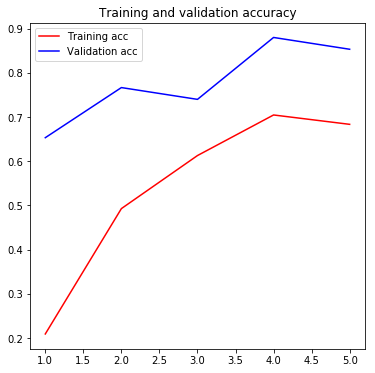

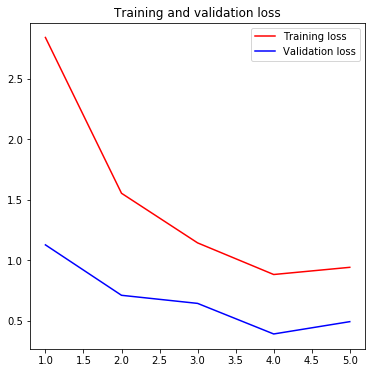

In [21]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

Train all layers

In [22]:
for layer in model.layers[:]:
    layer.trainable = True

In [23]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [24]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=5,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/5
27/27 [==============================] - 226s 8s/step - loss: 0.7764 - acc: 0.7438 - val_loss: 0.5422 - val_acc: 0.8267

Epoch 00001: val_acc improved from -inf to 0.82667, saving model to dog_breed_classifier_model.h5
Epoch 2/5
27/27 [==============================] - 228s 8s/step - loss: 0.8115 - acc: 0.7142 - val_loss: 0.6613 - val_acc: 0.7467

Epoch 00002: val_acc did not improve from 0.82667

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 3/5
27/27 [==============================] - 226s 8s/step - loss: 0.6749 - acc: 0.7632 - val_loss: 0.5449 - val_acc: 0.8267

Epoch 00003: val_acc did not improve from 0.82667
Epoch 4/5
27/27 [==============================] - 224s 8s/step - loss: 0.5993 - acc: 0.7936 - val_loss: 0.5270 - val_acc: 0.8133

Epoch 00004: val_acc did not improve from 0.82667
Epoch 5/5
27/27 [==============================] - 225s 8s/step - loss: 0.5519 - acc: 0.8219 - val_loss: 0.5692 - val_acc: 0.7800

Epoch 00005: va

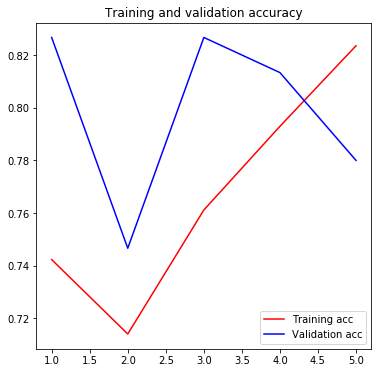

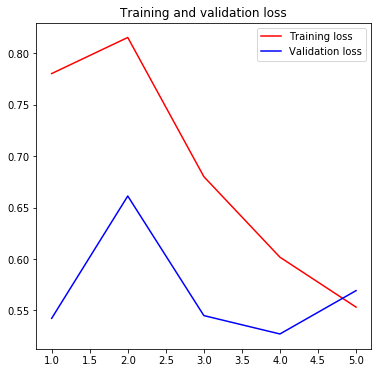

In [25]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [26]:
print(max(val_acc))

0.826666665871938


# DenseNet Training & Validation Accuracy & Loss

During 5 epochs of full fine-tuning, the model showed the following pattern:

Epoch 1:

Training accuracy: 74.38%

Validation accuracy: 82.67%

Best validation accuracy, model saved

Later epochs showed slight fluctuations, with validation accuracy between 74%–82%

Learning rate scheduling automatically reduced the LR twice because validation accuracy plateaued

# DenseNet Prediction

Predict on val_paths directly

In [27]:
IMG_SHAPE = (224, 224)

def predict_on_paths(model, paths, batch_size=32):
    all_preds = []
    n = len(paths)
    for i in range(0, n, batch_size):
        batch_paths = paths[i:i+batch_size]
        batch_imgs = []
        for p in batch_paths:
            img = imread(p).astype(np.float32)
            # make sure size is 224x224
            if img.shape[:2] != IMG_SHAPE:
                img = resize(img, IMG_SHAPE, anti_aliasing=True)
                img = (img * 255).astype(np.float32)
            img = preprocess_input(img)
            batch_imgs.append(img)
        batch_imgs = np.stack(batch_imgs, axis=0)
        batch_preds = model.predict(batch_imgs, verbose=0)
        all_preds.append(batch_preds)
    return np.vstack(all_preds)

# get predictions on the validation set
val_preds = predict_on_paths(model, val_paths, batch_size=32)
print("val_preds shape:", val_preds.shape)



val_preds shape: (150, 120)


Compute true / predicted labels

In [28]:
# true integer labels from one-hot
y_val_int = np.argmax(val_targets, axis=1)
y_val_pred_int = np.argmax(val_preds, axis=1)

print("Correctly classified:", np.sum(y_val_int == y_val_pred_int), "out of", len(y_val_int))


Correctly classified: 117 out of 150


Pick a subset of correctly classified examples

In [29]:
correct_indices = np.where(y_val_int == y_val_pred_int)[0]
print("Correct indices:", len(correct_indices))

N = 16
if len(correct_indices) > N:
    np.random.seed(42)
    chosen_correct = np.random.choice(correct_indices, size=N, replace=False)
else:
    chosen_correct = correct_indices


Correct indices: 117


Plot grid of correctly classified images

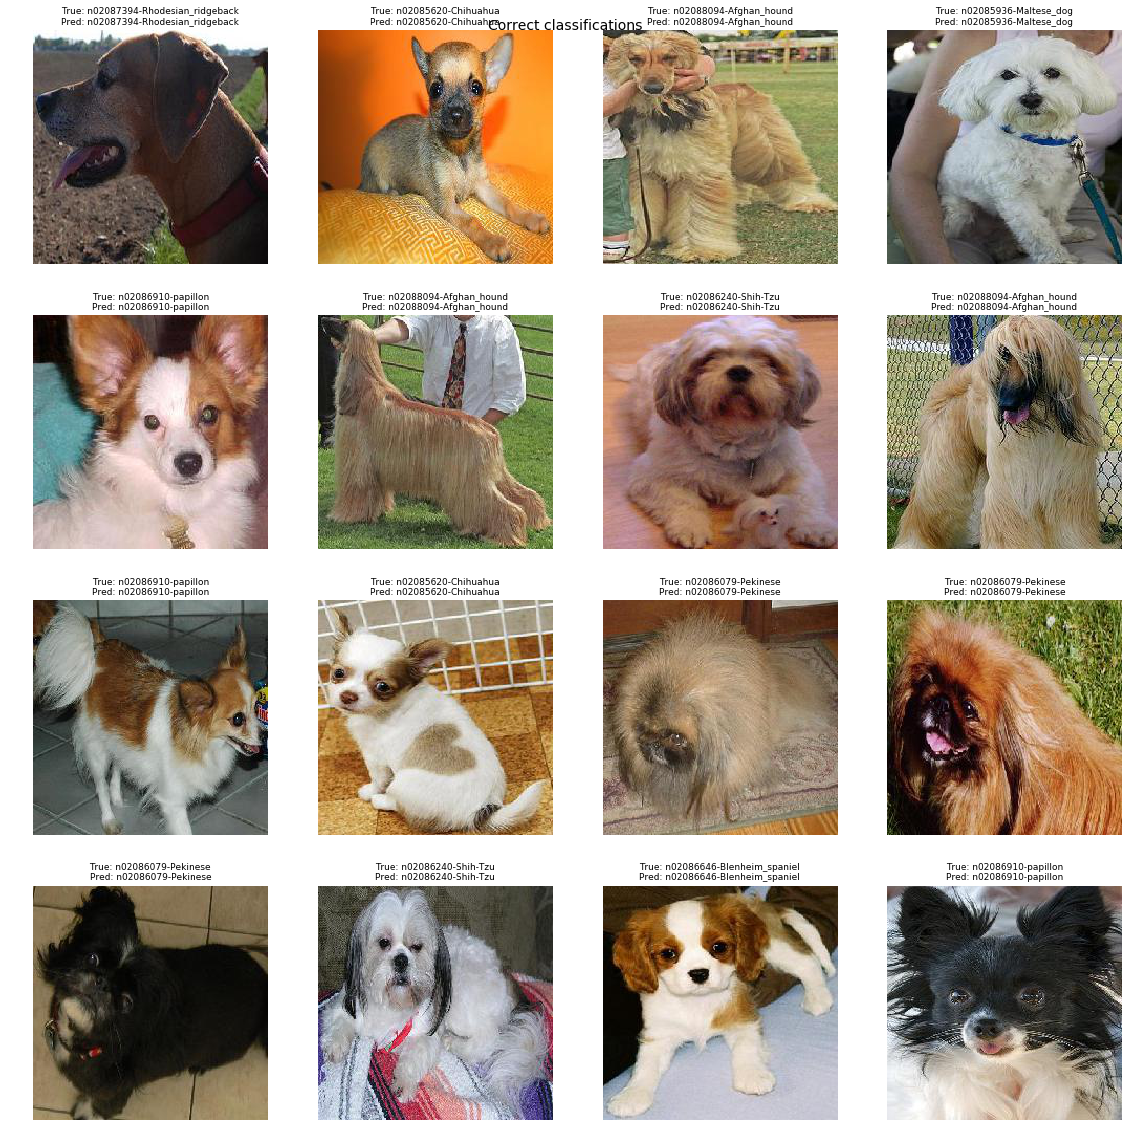

In [31]:
def show_examples(paths, y_true_int, y_pred_int, indices, label_maps_rev, n_cols=4, title_prefix="Correct"):
    n = len(indices)
    if n == 0:
        print("No examples to show.")
        return

    n_cols = n_cols
    n_rows = int(np.ceil(n / n_cols))

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for i, idx in enumerate(indices):
        img_path = paths[idx]
        img = imread(img_path)

        true_idx = y_true_int[idx]
        pred_idx = y_pred_int[idx]

        true_label = label_maps_rev[true_idx]
        pred_label = label_maps_rev[pred_idx]

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)

    plt.suptitle(f"{title_prefix} classifications", fontsize=14)
    plt.tight_layout()
    plt.show()

show_examples(
    val_paths,
    y_val_int,
    y_val_pred_int,
    chosen_correct,
    label_maps_rev,
    n_cols=4,
    title_prefix="Correct"
)


Classification report

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_val_int, y_val_pred_int))

              precision    recall  f1-score   support

           3       1.00      0.87      0.93        23
           4       0.88      0.58      0.70        12
           7       0.90      0.64      0.75        14
          26       1.00      0.88      0.94        17
          34       0.92      0.79      0.85        14
          71       0.83      0.75      0.79        20
          81       0.90      0.64      0.75        14
          87       0.53      0.80      0.64        10
          88       0.41      0.85      0.55        13
         111       0.80      0.92      0.86        13

   micro avg       0.78      0.78      0.78       150
   macro avg       0.82      0.77      0.78       150
weighted avg       0.84      0.78      0.79       150



Confusion matrix (numeric)

In [33]:
cm = confusion_matrix(y_val_int, y_val_pred_int)
print("Confusion matrix shape:", cm.shape)
print(cm)

Confusion matrix shape: (10, 10)
[[20  1  0  0  0  0  1  0  1  0]
 [ 0  7  0  0  0  0  0  5  0  0]
 [ 0  0  9  0  0  0  0  1  4  0]
 [ 0  0  0 15  0  2  0  0  0  0]
 [ 0  0  0  0 11  1  0  0  2  0]
 [ 0  0  1  0  1 15  0  0  1  2]
 [ 0  0  0  0  0  0  9  0  5  0]
 [ 0  0  0  0  0  0  0  8  2  0]
 [ 0  0  0  0  0  0  0  1 11  1]
 [ 0  0  0  0  0  0  0  0  1 12]]


# DenseNet Prediction Result


-- Some breeds are recognized perfectly:
Classes 3, 26, and 34 

These classes are easier for the model—visual features are distinctive.

-- Some breeds are not learned well:
Class 87 an 88

These classes likely contain:
1. Large intra-class variation (same breed looks very different)
2. Low inter-class variation (looks similar to other breeds)
3. Fewer training images
4. More background clutter

# DenseNet Summary
With only 10 images per breed, the DenseNet121 model achieves around 80% validation accuracy on a 10-class subset. The confusion matrix and per-class metrics show that some breeds are recognized almost perfectly, while others are frequently confused, especially when there are very few validation examples.

# SVM

Turn images into feature vectors 

In [34]:
IMG_SIZE = (64, 64)  # you can try 32x32, 64x64, etc.

def images_to_features(paths, img_size=IMG_SIZE):
    n = len(paths)
    X = np.zeros((n, img_size[0] * img_size[1] * 3), dtype=np.float32)

    for i, p in enumerate(paths):
        img = imread(p)                         # read image
        img = resize(img, img_size, anti_aliasing=True)  # resize to img_size
        img = img.astype(np.float32)
        img = img / 255.0                       # normalize to [0,1]
        X[i] = img.reshape(-1)                  # flatten to 1D
        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{n} images", end="\r")
    return X


In [35]:
print(len(train_paths))
X_train = images_to_features(train_paths, IMG_SIZE)
X_val   = images_to_features(val_paths,   IMG_SIZE)

print("X_train shape:", X_train.shape)
print("X_val shape:",   X_val.shape)

850
X_train shape: (850, 12288)
X_val shape: (150, 12288)


In [36]:
y_train_int = np.argmax(train_targets, axis=1)
y_val_int   = np.argmax(val_targets,   axis=1)

print("y_train_int shape:", y_train_int.shape)
print("y_val_int shape:",   y_val_int.shape)

y_train_int shape: (850,)
y_val_int shape: (150,)


Scale features

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Train SVM model

In [38]:
svm_clf = LinearSVC(C=1.0, max_iter=5000)

svm_clf.fit(X_train_scaled, y_train_int)

y_train_pred = svm_clf.predict(X_train_scaled)
y_val_pred   = svm_clf.predict(X_val_scaled)

train_acc = accuracy_score(y_train_int, y_train_pred)
val_acc   = accuracy_score(y_val_int,   y_val_pred)

print("SVM Train accuracy:", train_acc)
print("SVM Val accuracy:",   val_acc)

print("\nClassification report (SVM):")
print(classification_report(y_val_int, y_val_pred))

cm_svm = confusion_matrix(y_val_int, y_val_pred)
print("Confusion matrix (SVM):")
print(cm_svm)

SVM Train accuracy: 1.0
SVM Val accuracy: 0.22666666666666666

Classification report (SVM):
              precision    recall  f1-score   support

           3       0.53      0.35      0.42        23
           4       0.20      0.33      0.25        12
           7       0.20      0.29      0.24        14
          26       0.28      0.29      0.29        17
          34       0.27      0.21      0.24        14
          71       0.13      0.10      0.11        20
          81       0.21      0.21      0.21        14
          87       0.08      0.10      0.09        10
          88       0.00      0.00      0.00        13
         111       0.40      0.31      0.35        13

   micro avg       0.23      0.23      0.23       150
   macro avg       0.23      0.22      0.22       150
weighted avg       0.25      0.23      0.23       150

Confusion matrix (SVM):
[[8 1 1 4 1 1 3 2 2 0]
 [1 4 0 0 0 4 0 2 0 1]
 [2 1 4 2 1 1 3 0 0 0]
 [0 1 3 5 1 1 1 2 2 1]
 [1 1 0 1 3 2 1 1 3 1]
 [0 5 6 2 

# SVM Summary

-- overfitting--

Train Accuracy = 1.00
Validation Accuracy = 0.23

Using raw pixel inputs - Raw pixels give the SVM no semantic understanding of shape, texture, or breed-related patterns — just color values.
Very small dataset (≈100 samples)
So it memorizes the training set perfectly but fails to generalize.

The per-class metrics confirm this: most breeds have very low precision and recall. The confusion matrix is highly scattered, with predictions spread across many incorrect classes rather than concentrated along the diagonal.

# Hypertuning - DenseNet

In [39]:
from keras.optimizers import Adam

# freeze layers (same as before)
for layer in model.layers[:-6]:
    layer.trainable = False    

# explicitly set learning rate
learning_rate = 1e-3   # <<< CHANGE LR HERE

optimizer = Adam(lr=learning_rate)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["acc"]
)

history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=5)

Epoch 1/5
27/27 [==============================] - 230s 9s/step - loss: 0.7298 - acc: 0.7565 - val_loss: 0.8252 - val_acc: 0.7600
Epoch 2/5
27/27 [==============================] - 224s 8s/step - loss: 0.7450 - acc: 0.7342 - val_loss: 0.4344 - val_acc: 0.8467
Epoch 3/5
27/27 [==============================] - 226s 8s/step - loss: 0.6266 - acc: 0.7768 - val_loss: 0.7084 - val_acc: 0.7667
Epoch 4/5
27/27 [==============================] - 228s 8s/step - loss: 0.6092 - acc: 0.7829 - val_loss: 0.6165 - val_acc: 0.7867
Epoch 5/5
27/27 [==============================] - 227s 8s/step - loss: 0.6170 - acc: 0.7733 - val_loss: 0.4908 - val_acc: 0.8200


**Hypertuning Result**

Reduce learning rate to 0.001 

Epoch 1: val_acc = 0.76

Epoch 2: val_acc = 0.8467 (best)

Epoch 3–5: val_acc fluctuated between 0.7667–0.82

# Conclusion

I compared a classical machine learning baseline (Linear SVM on raw 64×64 RGB pixels) with a fine-tuned DenseNet121 model. The SVM achieved 100% training accuracy but only 22% validation accuracy, demonstrating heavy overfitting. In contrast, DenseNet121 achieved 84% validation accuracy, substantially outperforming the SVM. The deep model benefits from pretrained convolutional feature extraction and is able to generalize from a small number of examples, whereas the SVM struggles with high-dimensional raw pixel inputs and fails to capture the structural differences between dog breeds.
